In [1]:
import re
import json
import pandas as pd
from IPython.display import display

pd.set_option("display.max_colwidth", 4000)

with open("train_samples.jsonl", "r") as f:
    lines = [l.strip() for l in f]

df = pd.DataFrame([json.loads(l) for l in lines])

# Investigate NYT kickers in NewsRoom
Check if any of the summaries in NewsRoom is one of the kickers in NYT dataset

In [2]:
with open("kickers.txt", "r") as f:
    kickers = [l.strip().split('"')[1].lower() for l in f]

kickers = set(kickers)

In [3]:
df.shape

(10000, 12)

In [4]:
df.columns

Index(['url', 'archive', 'title', 'date', 'text', 'summary', 'compression',
       'coverage', 'density', 'compression_bin', 'coverage_bin',
       'density_bin'],
      dtype='object')

In [5]:
# Only those samples use NYT kickers as summaries
df[df["summary"].apply(lambda s: s.lower().strip() in kickers)][["title", "summary"]]

,title,summary


# Modifications to the density metric
- Redefine the density
    
    $ModifiedDensity = \frac{OldDensity}{|S|} ;$

    $0 <= ModifiedDensity <= 1$

    - Why does it make sense to do so?
    - Normalized metric (not affected by summary length)
    - More harsh on shorter summaries (because of how thersholding works)
    - Check the example on paper

- Use the 33% and 66% for finding the thresholds that divide articles into abstractive, mixed and extractive

- Do we need hyperparameter tuning for th1, th2 and cov_th?

In [6]:
import spacy

nlp = spacy.load("en_core_web_sm")

In [7]:
from tqdm import tqdm

tqdm.pandas()

In [8]:
df["text_len"] = df["text"].progress_apply(lambda s: len(str(s).split()))

# Use spacy to compute the number of tokens in a summary
df["summary_len"] = df["summary"].progress_apply(
    lambda s: len([t.text for t in nlp(s)])
)

100%|██████████████████████████████████████████████████████████████████| 10000/10000 [01:14<00:00, 133.81it/s]


In [9]:
df["modified_density"] = df["density"] / df["summary_len"]

In [10]:
# Find the new thresholds
th1, th2 = df["modified_density"].quantile(1/3), df["modified_density"].quantile(2/3)
cov_th = 0.85

th1, th2

(0.07958477508823529, 0.2988165680461538)

In [11]:
# Don't also consider high coverage summaries as abstractive ones
df["modified_density_bin"] = df.apply(
    lambda row: "abstractive"
    if row["modified_density"] <= th1 and row["coverage"] <=cov_th
    else "mixed"
    if row["modified_density"] <= th2
    else "extractive",
    axis=1,
)

In [12]:
# Adding a threshold for the coverage isn't that destructive
# The number of samples per bin is nearly preserved
df["modified_density_bin"].value_counts()

mixed          3690
extractive     3334
abstractive    2976
Name: modified_density_bin, dtype: int64

In [13]:
df.groupby("density_bin")["density"].describe().sort_index(
    key=lambda ind: [
        "2" if (x == "extractive") else "1" if (x == "mixed") else "0" for x in ind
    ]
)

,count,mean,std,min,25%,50%,75%,max
density_bin,,,,,,,,
abstractive,3301.0,0.942849,0.342498,0.000000,0.700000,0.976190,1.217391,1.500000
mixed,3291.0,3.406941,1.834874,1.510638,1.912404,2.692308,4.500000,8.187500
extractive,3408.0,23.652977,13.932746,8.192308,13.584295,20.028595,29.986726,133.122807


In [14]:
df.groupby("modified_density_bin")["modified_density"].describe().sort_index(
    key=lambda ind: [
        "2" if (x == "extractive") else "1" if (x == "mixed") else "0" for x in ind
    ]
)

,count,mean,std,min,25%,50%,75%,max
modified_density_bin,,,,,,,,
abstractive,2976.0,0.043921,0.019004,0.000000,0.029893,0.044741,0.058642,0.079585
mixed,3690.0,0.147823,0.065368,0.027489,0.094675,0.130194,0.195285,0.298776
extractive,3334.0,0.633984,0.245740,0.298817,0.424164,0.552047,0.902500,1.052632


In [15]:
# Large overlap in coverage
df.groupby("density_bin")["coverage"].describe().sort_index(
    key=lambda ind: [
        "2" if (x == "extractive") else "1" if (x == "mixed") else "0" for x in ind
    ]
)

,count,mean,std,min,25%,50%,75%,max
density_bin,,,,,,,,
abstractive,3301.0,0.640719,0.170484,0.000000,0.550000,0.666667,0.761905,1.0
mixed,3291.0,0.872449,0.090500,0.451613,0.814815,0.884615,0.941176,1.0
extractive,3408.0,0.965735,0.045298,0.627907,0.947368,0.978261,1.000000,1.0


### Check samples changing labels

In [16]:
df[["density_bin", "modified_density_bin"]].value_counts()

density_bin  modified_density_bin
extractive   extractive              2980
abstractive  abstractive             2559
mixed        mixed                   2541
abstractive  mixed                    721
extractive   mixed                    428
mixed        abstractive              417
             extractive               333
abstractive  extractive                21
dtype: int64

In [17]:
for old_label in ["extractive", "mixed", "abstractive"]:
    for new_label in ["extractive", "mixed", "abstractive"]:
        if old_label == new_label:
            continue
        if "abstractive" not in [old_label, new_label]:
            continue
        sub_df = df.loc[
            (df["density_bin"] == old_label)
            & (df["modified_density_bin"] == new_label),
            ["coverage", "modified_density", "density", "summary", "text"],
        ]
        if sub_df.shape[0]:
            print(f"{old_label} -> {new_label}")
            display(sub_df.sample(2))

mixed -> abstractive


,coverage,modified_density,density,summary,text
4932,0.833333,0.046296,1.666667,'Man of Steel' took Superman in a direction he never went in the comic books -- and it looks like 'Batman v Superman' is about to make an even worse mistake.,"This Friday, March 25th, Batman V Superman: Dawn of Justice hits theaters in the U.S. It's a sequel to 2013's Man of Steel with at least triple the superhero protagonists. The studio's intention is to kickstart a whole new franchise of DC Comics-based movies.\n\nBut as a lifelong Superman fan — the target audience, in theory — I find myself with low expectations and raised hackles.\n\nThe first problem is that Batman v Superman is helmed by the same director who gave us the mess that was Man of Steel, Zack Snyder. Though Snyder claims to understand his subject, his actions speak louder.\n\n“People are always like ‘You changed Superman.’ If you’re a comic book fan, you know that I didn’t change Superman."" Snyder said recently. ""If you know the true canon, you know that I didn’t change Superman.""\n\nAs someone who spent her entire teen years immersed in Superman comics, I had to say: Challenge accepted, Snyder. Read on to discover why you're wrong.\n\nI only saw Man of Steel once; my poor heart couldn't take another viewing. My blood pressure rises every time I hear it mentioned, especially the epic fail that was the disastrous final act. I will also admit that I adored Amy Adams' Lois Lane, and that a lot of my personal issues with the film are due to a general apathy towards stories that focus on Superman's homeworld of Krypton, and an aesthetic dislike of CGI-heavy sci-fi scenes.\n\nBut above all, the movie was a character assassination of the Superman I know and love, the one Snyder claims to have portrayed perfectly.\n\nThere are so many moments I could point to as Snyder and his team utterly failing to understand the core of the character: Superman letting Pa Kent die in order to keep his powers a secret; Superman not seeming to care to prevent the destruction of Metropolis; Superman rendered in the darkest color palette imaginable, with a perpetual scowl on Henry Cavill's chiseled face.\n\nTurning a superhero defined by his optimism for mankind into a gritty depressive without any real reasoning or character growth behind it shows Snyder's obvious attempt to win the Dark Knight Returns crowd — but without any of Dark Knight director Christopher Nolan's storytelling skills.\n\nYes, in the comics, Clark Kent grew up an outcast, hiding his power in a small town, feeling alone. But he also grew up with two loving and devoted parents, who instilled him with their values and taught him about the best mankind had to offer. That is established in every incarnation of the hero, from every comics reboot to every other TV show and film. This Superman would not let his father die when he had the power to do something about it. He would not walk the Earth feeling utterly alone when he had at least those two in his corner. No way he would let a city get basically destroyed with their voices in his ear.\n\nFor proof of all this, there's no better place to start than Jeph Loeb's 1998 classic Superman for All Seasons:\n\nMinutes after Man of Steel hit theaters, much of the Internet knew how the film ended: Superman kills his fellow Kryptonian enemy General Zod. Yes, Zod was about to kill (more) innocent humans before Superman snapped his neck. Ostensibly this was to prevent more deaths.\n\nBut Superman, Clark Kent, Kal-El, does not kill. This cast-iron rule was put into place in the comics in 1940, and has held firm ever since — through world war and global catastrophe. Other than a few instances set in ""What If"" stories, ""elseworlds"" or alternate dimensions, it's remained the ultimate ideal of the character.\n\nIndeed, even in the world of What If, you can't escape how essential the rule is to Superman. In one of the most classic elseworld stories, ""Whatever Happened to the Man of Tomorrow"" fro

abstractive -> extractive


,coverage,modified_density,density,summary,text
5871,1.0,0.333333,1.0,It was 1953,"On its face, the annual White House Easter Egg Roll is an occasion for the commingling of adorable children and fluffy bunnies—of either the four-legged or the full-grown-adult-in-costume variety. But it’s hard to imagine anything taking place on White House grounds without the undercurrent of politics, even if the majority of attendees, three-feet-high and preoccupied with rolling eggs, remain unaware.\n\nThe Easter Egg Roll has twice been a venue for conversations about inclusion and diversity. In 2006, around 100 gay and lesbian couples and their children attended the event, despite the shouts of a small group of protesters, to make a statement about the different kinds of families that make up America. During President Obama’s first year in office, he formally invited gay and lesbian families to participate.\n\nMore than half a century earlier, during his first year in office, President Eisenhower restored the tradition after a twelve-year hiatus. On that day in 1953, First Lady Mamie Eisenhower was disturbed to see that black children were peering in at the festivities from beyond the gates, instead of taking part. The following year, she invited African-American familes to join for the first time since the tradition officially began in 1878, a small but symbolic blip on the path to integration.\n\nBut on that April morning, attendees were mostly focused on figuring out what, exactly, an egg roll was. As a TIME briefing reported, “No one seemed to know what to do at an egg roll. Some bowled eggs across the greensward; others tossed them high in the air with occasional disasters.” The first aid station, consequently, was quite busy.\n\nLiz Ronk, who edited this gallery, is the Photo Editor for LIFE.com. Follow her on Twitter at @LizabethRonk."
2503,1.0,1.000000,1.0,Sen.,"WASHINGTON – Sen. Marco Rubio, the freshman senator from Florida and White House hopeful, defended his tougher rhetoric on foreign policy and said Americans “have to recognize the balance of power in the world is shifting.”\n\nRubio said on “Fox News Sunday” that the “rise of rogue states like North Korea and Iran,” as well as non-state groups like the Islamic State, have shifted the priorities for the U.S.\n\n“They are all different threats,” he said.\n\nDuring the exclusive interview, Rubio also defended former President George W. Bush’s decision to invade Iraq based on the information known at the time.\n\nLast week, Fox News’ Megyn Kelly asked likely GOP contender Gov. Jeb Bush whether he would have authorized the war “knowing what we know now.”\n\nIn that Fox News interview, Bush said he would have, while acknowledging ""mistakes.""\n\nThat response touched off a wave of criticism, with both Republicans and Democrats saying there would have been no reason to go to war, without intelligence showing weapons of mass destruction.\n\nRubio’s appearance on “Fox News Sunday” comes during the same week he delivered a key foreign policy speech in New York, where he defended the use of military power and called on the U.S. to aggressively confront China, Russia and other nations he said threaten American economic interests.\n\n“We simply cannot afford to elect as our next president one of the leading agents of this administration’s foreign policy – a leader from yesterday whose tenure as secretary of state was ineffective at best and dangerously negligent at worst,” he said during his speech to the Council on Foreign Relations in New York.\n\nRubio also answered criticism that he had gone soft on immigration reform.\n\n“It’s not that we bailed, it’s that we don’t have the votes to pass it,” Rubio said. “In fact, we have less votes for comprehensive immigration reform today than we did two years ago when that passed.”\n\nRubio blamed the dip in interest on “the last election, because of unilateral actions the president took through executive order, because of a border crisis, beca

abstractive -> mixed


,coverage,modified_density,density,summary,text
7364,0.714286,0.142857,1.000000,"Power Sheet - August 5, 2016","Editor-at-Large Jennifer Reingold (@jennrein) is filling in for Geoff Colvin this week.\n\nOn this, the first day of the 2016 Rio Olympics, it’s worth talking a little bit about teamwork. Normally, as a recent piece in the Harvard Business Review.com by HBS professor Gautam Mukunda (h/t to @cliftonleaf for the suggestion) makes clear, teams (really, any organization) tend to share the same values and beliefs. Having both a common goal and an agreed-upon way of getting there is what makes the “teamwork” part happen. But what happens if your team’s beliefs and your values don’t align? Which do you follow?\n\nThere are two relevant case studies that come to mind: First, as Mukunda analyzes brilliantly, the Republican Party. Some Republicans have chosen their values over their team, refusing to endorse Donald Trump because they don’t think he represents the things that are the essence, to them, of being a Republican (Mitt Romney and the Bush family fall into this camp). Others, such as Paul Ryan and Mitch McConnell, have criticized Trump for statements that they don’t agree with (particularly those relating to race), but continue to endorse him, demonstrating, in Mukunda’s words, that while they believe in inclusivity, it is not one of their fundamental values: “Because values are what you do when the choice is hard,” he writes.\n\nAnother example is the Russian Olympic team, now much diminished after many of the athletes were banned for doping. In Russia, like other countries, there is a fundamental belief in athletic superiority as a proxy for national superiority. It is clear that there was intense pressure to do whatever it took to win for the home nation—even if that meant abandoning one’s core values of fair play. The choice is an ugly one, filled with personal danger as well.\n\nBut there were leaders on that team—most notably, in my view, Yuliya Stepanova, who blew the whistle, but then was not allowed to compete because she had admitted to previous doping. She chose values over beliefs—and still has lost her livelihood. She is, however, a leader. As Mukunda writes: “Leaders aren’t judged just by the everyday choices they make. They’re measured most importantly by what they do when every option seems like a bad one.”\n\nYou can share Power Sheet with friends and followers here."
132,0.800000,0.088889,1.333333,Of a Kind's Erica Cerulo explains the dos and don'ts of brand voice.,"When my business partner Claire Mazur and I developed the idea for our company, Of a Kind in 2010, establishing our voice was a serious undertaking. We were creating a website to sell pieces from up-and-coming fashion designers and also to tell their stories, and we knew that figuring out how to speak to our audience — not just what to say but also how to say it — would be key in shaping people’s perception of what we were doing and selling.\n\nHaving come from the world of magazine editorial, cementing that tone was something I was excited to tackle. And though this project was especially crucial to our ecommerce business with its content-heavy approach, really, every company under the sun has to think about the voice and the personality of its messaging — how do you write an Instagram caption or respond to user feedback if you don't know what your business sounds like? Do you open customer service emails with “Hey, Kanye!” or “Dear Mr. West?” Below, four tactics that have helped us define our vibe that we think will serve you well, too.\n\nBefore Claire and I started Of a Kind, we spent time identifying our target customers. Initially, we were talking to these imagined people — think Kate, the corporate creative who mourned the loss of Domino magazine and loved Michelle Williams’s style. But now that we've been in business for nearly four years, we have some knowledge — data! — re: who our customer is: She’s a 30-year-old woman who shops

# Distribution of affected abstractive samples

Text(0.5, 1.0, 'In')

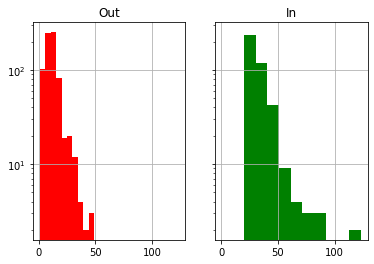

In [18]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
df.loc[
    (df["density_bin"] == "abstractive")
    & (df["modified_density_bin"] != "abstractive"),
    "summary_len",
].hist(log=True, ax=ax[0], color="red")

df.loc[
    (df["density_bin"] != "abstractive")
    & (df["modified_density_bin"] == "abstractive"),
    "summary_len",
].hist(log=True, ax=ax[1], color="green")

ax[0].set_title("Out")
ax[1].set_title("In")

# Still some really short and really long summaries are still considered as abstractive
- Let's use heuristics then

In [19]:
df[df["modified_density_bin"] == "abstractive"].sort_values(by="summary_len", ascending=True)[
    ["density_bin", "modified_density_bin", "coverage", "title", "summary", "summary_len", "text_len"]
].head(2)

,density_bin,modified_density_bin,coverage,title,summary,summary_len,text_len
253,abstractive,abstractive,0.0,"Intel finds chipset problem, says it will cost $700 million to fix",...,1,2020
7849,abstractive,abstractive,0.0,Spring: Season of Bias in Girls' Soccer?,sprino,1,1363


In [20]:
df[df["modified_density_bin"] == "abstractive"].sort_values(by="summary_len", ascending=False)[
    ["density_bin", "modified_density_bin", "coverage", "title", "summary", "summary_len", "text_len"]
].head(2)

,density_bin,modified_density_bin,coverage,title,summary,summary_len,text_len
1528,abstractive,abstractive,0.630390,"Conn. gunman broke in, shot kids multiple times","(AP) &acirc;�� The gunman behind the Connecticut elementary school massacre stormed into the building and shot 20 children at least twice with a high-powered rifle, executing some at close range and killing adults who tried to stop the carnage, authorities said Saturday. The tragedy has plunged Newtown into mourning and added the picturesque New England community of handsome Colonial homes, red-brick sidewalks and 27,000 people to the grim map of towns where mass shootings in recent years have periodically reignited the national debate over gun control but led to little change. Families as far away as Puerto Rico planned funerals for victims who still had their baby teeth, world leaders extended condolences, and vigils were held around the U.S. Police shed no light on what triggered Adam Lanza, 20, to carry out the second-deadliest school shooting in U.S. history, though state police Lt. Paul Vance said investigators had found &quot;very good evidence ... that our investigators will be able to use in painting the complete picture, the how and, more importantly, the why.&quot; [...] another law enforcement official, speaking on condition of anonymity, said investigators have found no note or manifesto from Lanza of the sort they have come to expect after murderous rampages such as the Virginia Tech bloodbath in 2007 that left 33 people dead. Lanza shot to death his mother, Nancy Lanza, at the home they shared, then drove to the school in her car with at least three of her guns, forced his way in and opened fire, authorities said. Education officials said they had found no link between Lanza's mother and the school, contrary to news reports that said she was a teacher there. Lanza was believed to have suffered from a personality disorder, said a law enforcement official who spoke on condition of anonymity. Another law enforcement official, also speaking on condition of anonymity, said Lanza had been diagnosed with Asperger's, a mild form of autism often characterized by social awkwardness. The law enforcement officials insisted on anonymity because they were not authorized to discuss the unfolding investigation. Lanza's family was struggling to make sense of what happened and &quot;trying to find whatever answers we can,&quot; his father, Peter Lanza, said in a statement late Saturday that also expressed sympathy for the victims' families. Asked whether the town would recover, Maryann Jacob, a clerk in the school library who took cover in a storage room with 18 fourth-graders during the shooting rampage, said: We have to.",487,10604
4596,abstractive,abstractive,0.476038,How Dandelion Chocolate goes from beans to bars,"How Dandelion Chocolate goes from beans to bars Like so many Bay Area startups, Dandelion Chocolate founders Todd Masonis and Cameron Ring got their start in a garage in Silicon Valley. Cocoa and sugar are the only ingredients in Dandelion Chocolate’s bars. Chocolatiers, on the other hand, jump into the process later, buying pre-made chocolate and shaping it into treats. “Not a lot of people make chocolate, and very few of them really see the process,” said Masonis, the CEO. The first thing you notice when you enter the cafe is the smell: chocolate. The cafe, which opened in early 2013, is an open space, with wooden beams providing support and atmosphere. The counter has a modern feel, with pastries laid out on simple wooden plates. Sacks of beans are stacked on the floor, and bright orange buckets hold beans ready for sorting. Sorters throw out about 30 percent of every batch, picking out chipped beans, sticks and garbage, according to Dandelion’s Jennifer Roy. Beans are then deposited in a winnowing machine that separates husks from nibs — the part of the bean that provides chocolate’s flavor. Metal cylinders called melangers grind the nibs and suga

# More central summaries (according to number of tokens in the summary)

In [21]:
df[df["density_bin"] == "abstractive"].sort_values(by="summary_len", ascending=False)[
    ["density_bin", "modified_density_bin", "coverage", "title", "summary", "summary_len", "text_len"]
].head(1000).tail(5)

,density_bin,modified_density_bin,coverage,title,summary,summary_len,text_len
3805,abstractive,abstractive,0.807692,Mending Fences at World Bank,"Robert B. Zoellick, the new chief of the World Bank, will need to smooth ruffled feathers left by his predecessor Paul D. Wolfowitz.",26,1228
3172,abstractive,abstractive,0.615385,Senate sends repeal of tax reports to Obama,"Senate sends repeal of tax reports to Obama - On Politics: Covering the US Congress, Governors, and the 2010 Election - USATODAY.com",26,316
3710,abstractive,abstractive,0.730769,"Nación ESPN pitches for sports-loving, code-switching Latino youth","The new weekly show on ESPN2 is presented in English but slipping easily into Spanish is part of its makeup, much like its target audience",26,803
5473,abstractive,mixed,0.923077,5th teen held in alleged NY gang rape,"A fifth person is in custody in connection with a woman's alleged gang rape in a Brooklyn playground, a law enforcement official said.",26,614
678,abstractive,abstractive,0.769231,Villa poised for Atletico Madrid move,Barcelona have reached an agreement in principle for the transfer of striker David Villa to Atletico Madrid. Barcelona striker Villa poised for Atletico Madrid move,26,150


In [22]:
df[df["density_bin"] == "abstractive"].sort_values(by="summary_len", ascending=False)[
    ["density_bin", "modified_density_bin", "coverage", "title", "summary", "summary_len", "text_len"]
].tail(1000).head(5)

,density_bin,modified_density_bin,coverage,title,summary,summary_len,text_len
6564,abstractive,mixed,0.666667,Indoor Tanning: Risk For Skin Cancer is High Even Without Sunburns,New research shows indoor tanning can cause skin cancer even if you never get burnt,15,515
966,abstractive,abstractive,0.666667,Newt Gingrich's strategy for another Republican Revolution; 2+2=4 -- full video,Former GOP Speaker details plans to defeat Obama -- and a 2012 presidential candidacy?,15,351
4563,abstractive,abstractive,0.533333,Court Limits Public-Worker Claims,Continuing coverage of the Supreme Court nomination and confirmation process from The Washington Post.,15,742
7287,abstractive,abstractive,0.666667,"So, is Donetsk the next Crimea?","The eastern Ukrainian city is declared the Donetsk Peopleâ��s Republic.""",15,463
9932,abstractive,mixed,0.666667,Philip Zimbardo Thinks We All Can Be Evil,The psychologist on what the Stanford prison experiment continues to reveal about human nature.,15,752


# Check how the coverage/ density are distributed

In [23]:
import seaborn as sns

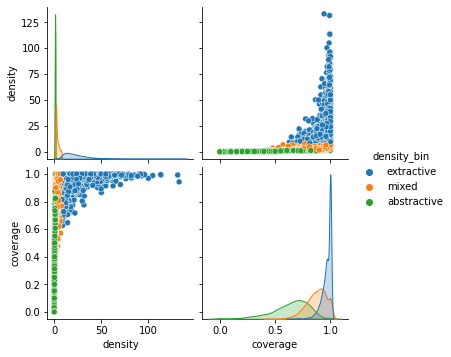

In [24]:
sns.pairplot(
    df[["density", "coverage", "density_bin"]],
    hue="density_bin",
    hue_order=["extractive", "mixed", "abstractive"],
)

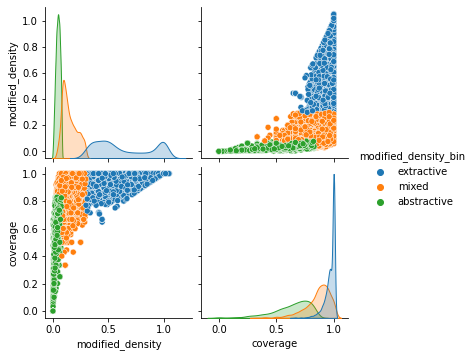

In [25]:
sns.pairplot(
    df[["modified_density", "coverage", "modified_density_bin"]],
    hue="modified_density_bin",
    hue_order=["extractive", "mixed", "abstractive"],
)